<a href="https://colab.research.google.com/github/Albly/Tissue_segmentation/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet pytorch-lightning
!pip install --quiet wandb

!wget https://raw.githubusercontent.com/Albly/Tissue_segmentation/main/loss.py
!wget https://raw.githubusercontent.com/Albly/Tissue_segmentation/main/pl.py

     |████████████████████████████████| 582 kB 4.4 MB/s 
     |████████████████████████████████| 136 kB 62.8 MB/s 
     |████████████████████████████████| 398 kB 60.3 MB/s 
     |████████████████████████████████| 596 kB 52.6 MB/s 
     |████████████████████████████████| 1.1 MB 28.7 MB/s 
     |████████████████████████████████| 271 kB 31.8 MB/s 
     |████████████████████████████████| 94 kB 2.6 MB/s 
     |████████████████████████████████| 144 kB 51.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.1.1 which is incompatible.
     |████████████████████████████████| 1.7 MB 4.4 MB/s 
     |████████████████████████████████| 181 kB 46.0 MB/s 
     |████████████████████████████████| 144

In [42]:
import torch
from torch import nn
import numpy as np 
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import glob
import h5py
import cv2
import math
import pytorch_lightning as pl
import random
import wandb
import albumentations as A
from copy import copy

In [33]:
# TODO wandb is ok or tensorboard?
USE_WANDB_LOGGER = True
if USE_WANDB_LOGGER:
    wandb.init(project="Tissue_segmentation", entity="sk_team")

NameError: name 'wandb' is not defined

In [43]:
'''Unzip dataset on your drive or add shortcut from shared files'''
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/

data_path = 'tissue-segment/'

#!git clone https://github.com/Albly/Tissue_segmentation.git

In [44]:
class Tissue_Dataset(Dataset):
    def __init__(self, path, transform = None):
        masks_name = glob.glob(path+'/*mask.jpg')
        image_names = glob.glob(path+'/*[!mask].jpg')
        
        assert len(masks_name) == len(image_names), 'Different amount of images and masks'

        masks_tmp, images_tmp = [], []
        for mask in masks_name: masks_tmp.append(mask[:-9])     # discard _mask.jgp 
        for image in image_names: images_tmp.append(image[:-4]) # discard .jpg
        
        assert all(item in masks_tmp for item in images_tmp) , 'Different files' # check that subsest are the same
        
        self.files = images_tmp
        self.transform = transform
        
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.files[idx]+'.jpg', cv2.IMREAD_GRAYSCALE)  # load image in grayscale
        mask = cv2.imread(self.files[idx]+'_mask.jpg', cv2.IMREAD_GRAYSCALE)   # load mask in grayscae
        mask = cv2.threshold(mask,122,255,cv2.THRESH_BINARY)[1]     # binirize mask to [0;255] using threshold 122
        
        if self.transform is not None:
            transformed = self.transform(image=image, mask = mask)  # do augmentation
            image = transformed['image']    
            mask = transformed['mask']
        
        image, mask = torch.tensor(image), torch.tensor(mask).type(torch.float32)       # tranform from np to torch        

        return torch.unsqueeze(image, dim = 0), torch.unsqueeze(mask, dim =0) # output with shape of [N,C,W,H] 


def get_transforms(train_patch_size = 64, test_patch_size = 1500):
    '''returns augmentations transforms for both datasets
       Applies patch sampling to data.
    '''

    train_transform = A.Compose([
        A.RandomCrop(height=train_patch_size, width=train_patch_size, always_apply = True),
        A.HorizontalFlip(always_apply = False, p = 0.5),
        A.VerticalFlip(always_apply = False, p = 0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.5),
        #TODO: add other transfroms
    ])
    
    test_transform = A.Compose([
        A.RandomCrop(height = test_patch_size, width = test_patch_size, always_apply = True)
    ])

    return train_transform, test_transform


def prepare_DataLoaders(path, train_test_split = 0.9, batch_size = (10,1), transforms = (None, None)):
    fullDataset = Tissue_Dataset(data_path, transforms[0])  # get full dataset and assign train augmentation 
    train_size = int(train_test_split * len(fullDataset))  
    test_size = len(fullDataset) - train_size
    
    # split dataset to 2 subsets
    trainDataset, testDataset = torch.utils.data.random_split(fullDataset, [train_size, test_size])
    testDataset.dataset = copy(fullDataset)             # both subsets uses the same dataset object. Need a copy for using different transfroms
    testDataset.dataset.transform = transforms[1]       # assign test transform 
    # construnct dataLoaders
    trainLoader = DataLoader(trainDataset, batch_size = batch_size[0], shuffle = True)
    testLoader = DataLoader(testDataset, batch_size = batch_size[1], shuffle = True)
    return trainLoader, testLoader

In [45]:
train_transform, test_transform = get_transforms(train_patch_size = 256,
                                                test_patch_size = 1500)

trainLoader, testLoader = prepare_DataLoaders(path = data_path,
                                              train_test_split = 0.9,
                                              batch_size = (10,1),
                                              transforms = (train_transform, test_transform)
                                              )

Train loader
Shape of images is : torch.Size([10, 1, 256, 256])
Shape of masks is : torch.Size([10, 1, 256, 256])
<built-in method type of Tensor object at 0x7eff14de0e00>


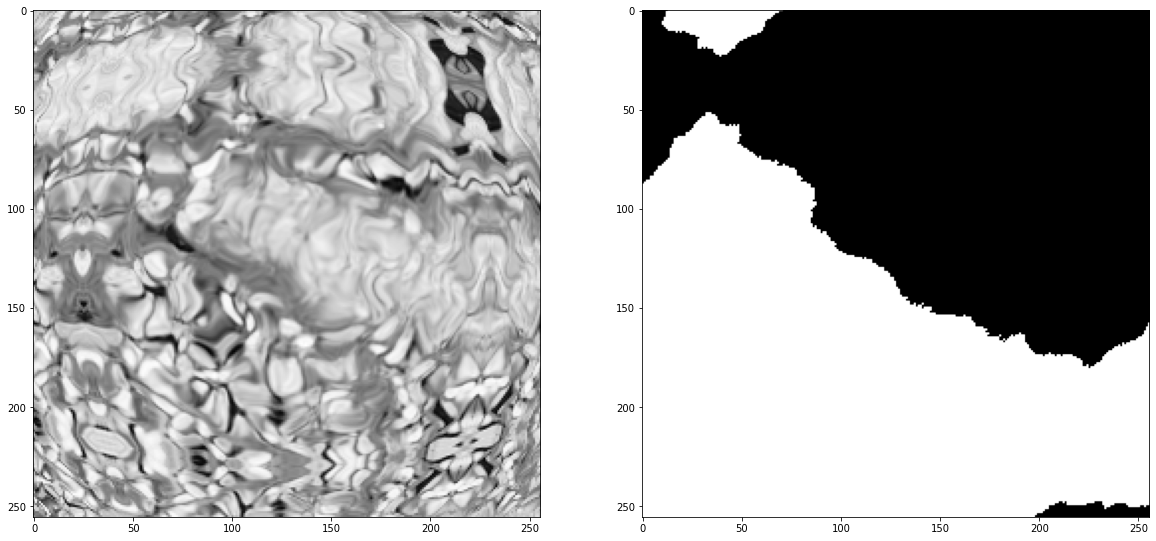

In [46]:
plt.figure(figsize=(20,20))
mask = None
for image,mask in trainLoader:
    print('Train loader')
    print('Shape of images is :', image.shape)
    print('Shape of masks is :', mask.shape)
    print(image.type)
    plt.subplot(1,2,1)
    plt.imshow(image[0,0], cmap= 'Greys')
    plt.subplot(1,2,2)
    plt.imshow(mask[0,0], cmap= 'Greys')
    break

# plt.figure()
# for image,mask in testLoader:
#     print('Test loader')
#     print('Shape of images is :', image.shape)
#     print('Shape of masks is :', mask.shape)
#     plt.subplot(1,2,1)
#     plt.imshow(image[0,0], cmap= 'Greys')
#     plt.subplot(1,2,2)
#     plt.imshow(mask[0,0], cmap= 'Greys')
#     break

In [54]:
import torch
from loss import *

size = 3
TR = torch.randint(0,2,[size,size],dtype=torch.uint8)*255
PR = torch.randint(0,2,[size,size],dtype=torch.uint8)*255

TP,TN,FP,FN = calc_val_data_dice(TR, PR)
dice_score = calc_val_loss_dice(TP,TN,FP,FN)

I,U,T = calc_val_data_IoU(TR,PR)
IoU,Acc = calc_val_loss_IoU(I,U,T)

print("TP",TR)
print("PR",PR)
print("TP",TP)
print("TN",TN)
print("FP",FP)
print("FN",FN)
print("dice_score",dice_score)
print("IoU,Acc",IoU,Acc)

TP tensor([[255,   0, 255],
        [255,   0,   0],
        [  0,   0,   0]], dtype=torch.uint8)
PR tensor([[  0, 255, 255],
        [255, 255,   0],
        [255,   0,   0]], dtype=torch.uint8)
TP tensor([[False, False,  True],
        [ True, False, False],
        [False, False, False]])
TN tensor([[False, False, False],
        [False, False,  True],
        [False,  True,  True]])
FP tensor([[False,  True, False],
        [False,  True, False],
        [ True, False, False]])
FN tensor([[ True, False, False],
        [False, False, False],
        [False, False, False]])
dice_score tensor(0.5000)
IoU,Acc tensor([0.4286, 0.3333]) tensor([0.5000, 0.6667])
